# Identifying War Criminals using OSINT and Facial Recognition

## Introduction
War crimes are being committed in Ukraine and facial recognition is being leveraged to identify the perpetrators. Unprecedented access to both ML tools and scrapped social network data allows us to track potential suspects of war-time offenses. Currently, these efforts depend on the proprietary software of private companies, such as [Clearview AI](https://www.washingtonpost.com/technology/2022/04/15/ukraine-facial-recognition-warfare/) and [FindClone](https://www.wired.com/story/facial-recognition-identify-russian-soldiers/). Here we show how data scientists and citizen investigators can carry out their own analyses, using publicly available datasets in Python libraries. In the process, we’ll learn about the benefits and dangers of facial recognition tech. We’ll also, through careful analysis, identify the perpetrator of brutal, heartless crime.

The crime in question occurred in early March and was recorded by security cameras from multiple angles. That day, Russian invaders pulled up at a roadside store along the main highway outside of Kyiv. Two Ukrainian citizens walked up to the invaders. They spoke; the invaders asked the citizens for cigarettes. The citizens complied and then began to walk away. Suddenly, the soldiers raised their rifles and [shot the Ukrainians in the back]( https://www.cnn.com/2022/05/11/europe/ukraine-video-russian-soldiers-shoot-civilians/index.html). Afterwards, the killers broke into the building, to look for vodka. A CCTV camera recorded the [close-up face]( https://www.bbc.com/news/world-europe-61425025) of one of the killers.  

We’ll now proceed to load and analyze the killer’s face. Later, we’ll attempt to match the face with a large, open-source invader dataset.

## Analyzing the Killer’s Face

We have a screenshot of the grainy camera footage stored in file `war_criminals/murderer.png`.  Let’s start by loading that screenshot into Python and displaying the image.

**Code Listing 1: Visualizing the Killer**

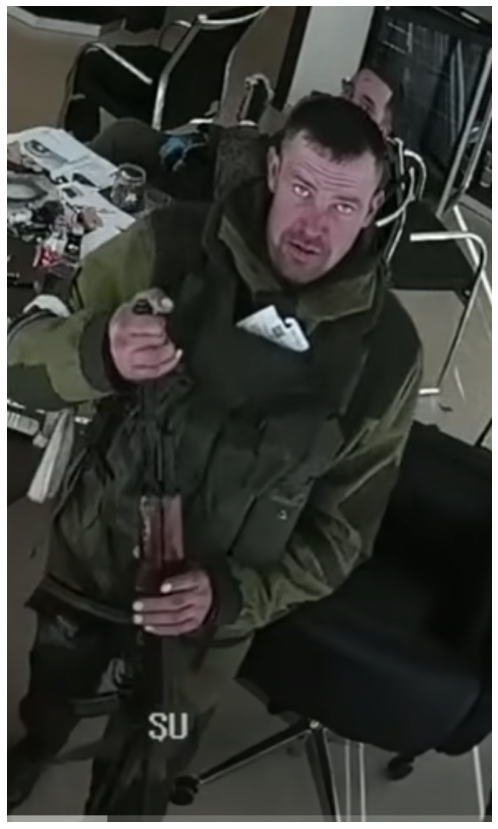

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = 'war_criminals/murderer.png'
# Loads the image as NumPy array.
murderer_image = mpimg.imread(image_path)
# Sets the dimensions of 
plt.figure(figsize = (15, 15))
# Displays visualizes the image.
plt.imshow(murderer_image)
plt.axis('off')
plt.show()

The photo is of a soldier who has just spotted the video-camera. He’s about the swing the rifle in his hands in order to bash the camera. The soldier is long-limbed with a lanky left arm that swings rather low. His face is unshaven, with a pointed nose and narrow, elongated ears. It’s hard to distinguish the color of his eyes. We do however see his short, brown hair. It’s difficult to tell his exact age though the man is fairly young. He’s probably no older than 40. All these details could become important as we try to match the war-criminal to our photo collection.

From this image, we will try to extract the face. For this purpose, we’ll use the open-source [DeepFace](https://analyticsindiamag.com/face-recognition-system-using-deepfacewith-python-codes/) library, which leverages neural network face analysis models that were first developed at Facebook. Below, we’ll call the `DeepFace.detectFace` function in to order to extract all faces present in the image.

**Code Listing 2: Extracting the Killer’s Face**

In [2]:
import matplotlib.pyplot as plt
from deepface import DeepFace
# We wrap our function call in a try/except statement to detect all errors. Our reasons for doing so
# will shortly become obvious.
try:
    faces = DeepFace.detectFace(img_path=image_path)
    print(f"Number of faces detected: {len(faces)}")
except Exception as e:
    print(e)

Face could not be detected. Please confirm that the picture is a face photo or consider to set enforce_detection param to False.


The `detectFace` function has thrown an error. DeepFace had difficulty identifying the face under its default settings. This is because the face is positioned at a crooked rightward angle as the killer stares up the at the camera. The face is misaligned, and to carry out further analysis we must first appropriately align it. The [RetinaFace](https://github.com/serengil/retinaface#) library, first published in 2019, will prove useful for this purpose. RetinaFace is able to detect and rotate faces by first detecting sub-components of the face, such as the eyes. If one eye is positioned higher than the other, then RetinaFace will rotate the image until both eyes are level. Afterwards, the full perimeter of the face becomes much easier to identify. Below, we’ll execute face alignment and detection using the ` RetinaFace.extract_faces` function.

**Code Listing 3: Aligning Faces Using RetinaFace**

In [3]:
from retinaface import RetinaFace
faces = RetinaFace.extract_faces(image_path)
print(f"Number of faces detected: {len(faces)}")

Number of faces detected: 1


A single face has been identified within the `faces` list. Let’s visualize that face and store its contents within a `murderer_face` variable.

**Code Listing 3: Visualizing the Killer’s Face**

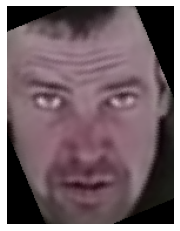

In [4]:
def plot_face(face):
    plt.imshow(face)
    plt.axis('off')
    plt.show()

murderer_face = faces[0]
plot_face(murderer_face)

The face has been extracted and aligned; the eyes are level. Now we can feed the rotated face into `DeepFace` for additional analysis. For example, calling the `DeepFace.analyze` function will classify the face based on age, race, sex, and dominant emotion. We should be cautious however when utilizing these classifiers since factors like age and emotion are notoriously difficult to predict.

**Code Listing 4: Analyzing the Killer’s Face**

In [5]:
analysis_dict = DeepFace.analyze(murderer_face, detector_backend='skip')
for key, value in analysis_dict.items():
    if type(value) == dict:
        continue
    
    print(f"{key}: {value}")

Action: race: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]   

dominant_emotion: neutral
age: 41
gender: Man
dominant_race: white


`DeepFace` predicts that the killer is a white man with a neutral expression, which is not particularly insightful or surprising. The model also estimates that the killer is 41 years old. This age is older than expected, though as previously mentioned, the `DeepFace` age prediction tool is not particularly well-tuned. Nonetheless, going forward, we’ll assume that the killer is no older than 41; that assumption will help us filter unnecessary suspects from our open-source dataset. With that in mind, let’s turn out attention to downloading suspect images from open-source data.

## Downloading Suspect Images from Open-Source Data

The [Social Media Analysis Toolkit (SMAT)](https://www.smat-app.com/) has recently [released material](https://twitter.com/SMAT_app/status/1539992559166148610) introducting the Invaders project. This is a Ukrainian initiative to crawl, archive, and analyze tens of thousands of social media profiles belonging to the Russian invaders. If we go to the website [invader.info](https://invader.info) we see photos of grim Russian soldiers. Though the site is not in English, Google Translate quickly reveals that the full invader dataset is available for download in JSON format from [https://invader.info/files/invaders.json](https://invader.info/files/invaders.json). We’ll now proceed to download that full data and convert it to a Python list. We’ll also measure the length of the list to count the number of soldiers in the data.

**Code Listing 5: Downloading the Invaders JSON**

In [6]:
import requests
json_url = "https://invader.info/files/invaders.json"
invaders = requests.get(json_url).json()
print(f"We downloaded a dataset containing {len(invaders)} invaders.")

We downloaded a dataset containing 34129 invaders.


The dataset contains over 34,000 invaders. This is too many individuals to match against our grainy photo. As we’ll see shortly, the false positive match-rate makes it unreasonable to check the matches by hand. We’ll need to curtail the dataset by doing some additional research. If we can identify the military units most likely to be associated with the war-crime, then we’ll be able to narrow the scope of our possible suspects. This is because the Invader dataset is based on a hacked spreadsheet of military personal [released by Anonymous]( https://fortune.com/2022/04/04/anonymous-leaks-russian-soldier-data-ukraine-invasion/). The spreadsheet contains soldiers’ names, and also their birthdays, ranks, and military units (aka the base numbers). This information is readily accessible within our JSON. Let’s print the aforementioned fields for the first soldier in the `invaders` list.

**Code Listing 6: Examining an Invader in the List**

In [7]:
for key in ['name', 'rank', 'base', 'birthDate']:
    print(f"{key}: {invaders[0][key]}")

name: Давлетбаев Мурат Айдарович
rank: Старший сержант
base: Войсковая часть 30632-3
birthDate: 1994-12-06


The first invader in the list is Murat Davletbaev (Давлетбаев Мурат Айдарович), a senior sergeant (Старший сержант) serving in military unit 30632. The military unit information is an incredibly valuable field! We can use it to decrease our list of suspects, if we identify the military unit that was stationed in the area during the crime. This will require us to put on our sleuthing hats and carry out an OSINT investigation.

### Investigating Online Clues to Identify the Russian Military Unit Present Near the Crime-Scene

Let’s start by examining a [CNN news-clip](https://www.youtube.com/watch?v=WGg7ZJlihi8) describing the crime. The killings occurred in the third week of the war along the main highway right outside of Kyiv. The killers had arrived in what appears to be stolen van. If we pause the news clip at 1:20, we’ll see some writing on the van. 

**Code Listing 7: Examining the Van Carrying the Killers**

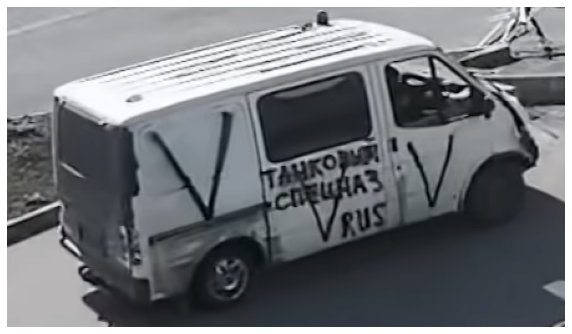

In [8]:
fname = 'images/Murder_Van.png'
image = mpimg.imread(fname)
plt.figure(figsize = (10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

That writing is a vital clue! It’s blurry but still quite readable to an Eastern European speaker. English-speaking investigators can easily obtain a translation by posting the image and translation request to an OSINT discord server, such as the server [run by Bellingcat]( https://discord.com/invite/bellingcat). The writing on the van says “ТАНКОВЫЙ СПЕЦНАЗ” (followed by “Rus” in Latin letters). Processing these words through Google Translate, we obtain the phrase “Tank Special Forces”. The killers are tank operators whose tank has been destroyed, or possibly dragged off by a Ukrainian tractor.

The killers belong to a tank unit that was operating along in main highway on the outskirts of Kyiv in the early weeks of the war. Given these constraints, we can identify the tank unit, either through some clever Googling, or by posting questions to an OSINT discord forum. Our research will reveal that the main highway in question is the Kyiv Zhytomyr highway, which one month into the invasion was with the [broken remains of Russian tanks](https://www.youtube.com/watch?v=vE4UiAcRXzw).  These tanks had [initially occupied the village of Dymitrivka]( https://zmi.st/2022/04/03/the-road-near-the-village-dmytrivka-on-the-zhytomyr-highway-is-littered-with-corpses-people-were-killed-by-russians-we-show-these-photos-because-we-want-the-whole-world-to-know-about-the-genoci/), arriving there on the first day on the war. Afterwards, the tanks spread through the highway next to the village, like cancer cells diffusing in the bloodstream. Can we identify the tank unit initially stationed at Dymitrivka? Yes we can!  As seen two minutes into this [subtitled Ukrainian news video](https://www.youtube.com/watch?v=ZiK2k8dCsRk), documents were uncovered in rubble of Dymitrivka that pinpoint the identity of the unit. The Russians tanks along that highway belonged to military unit 22150. By filtering the invaders on that unit, we can greatly reduce the scope of possible suspects.

### Filtering the List of Possible Suspects

We want to filter our list of soldiers based on whether each soldier belongs to military unit 22150. However, before we do so, we must discuss a problem with our dataset. As previously mentioned, the `base` key of each invader maps to a military unit that was reported in the Anonymous dataset. Unfortunately, that dataset is incomplete. Anonymous was unable to obtain military units for many of the soldiers. These missing units are tracked using a dash `'—'` with our data. If we count the number of dashes in `invaders`, we will see that many soldiers have missing units.

**Code Listing 8: Counting Invaders with a Missing Military Unit**

In [9]:
dash_count = len([invader for invader in invaders if invader['base'] == '—'])
print(f"{dash_count} invaders have not been assigned a military unit.")

10423 invaders have not been assigned a military unit.


Over 10K invaders have not been assigned a military unit. This number represents nearly 1/3rd of our invader datasets. Hence, if we filter by base, we run a one-in-three chance of filtering out war-criminals in our data. Fortunately, all is not lost. Russian soldiers have a habit of listing their military units directly on their social media sites. In fact, given the martial nature of their totalitarian society, it shouldn’t surprise that that Russian social media sites have a section for “Military Unit” (similar to how Facebook has a section for “City” or “Relationship Status”). This social media information has been scraped and stored within the `invaders` JSON. It is accessible via the `vk_listed_bases` key (where VK stands for [vk.ru]( https://vk.ru/), a popular Russian social media site.). Below, we’ll leverage both the `base` and `vk_listed_bases` keys to select those invaders that serve in military unit 22150.

_NOTE: It’s worth mentioning that Invaders data also includes social media friendship information. Theoretically, we can leverage that information to infer the missing military units. Many soldiers who serve together are also friends on social media. Consequently, if a soldier has multiple friends with a specific military unit, then they are more likely to serve in that same unit._

**Code Listing 9: Filtering by Military Unit**

In [10]:
import re
def filter_by_military_unit(invaders, military_unit_string):
    # The military unit string is compiled into a regular expression that can be matched to
    # the text. Later, this will allow us to match multiple possible military units using a 
    # single regex string.
    regex = re.compile(military_unit_string)
    invaders_filtered = []
    for invader in invaders:
        if regex.search(invader['base']):
            invaders_filtered.append(invader)
        # The `vk_listed_bases` key can theoratically map to multiple bases, if and invader is linked
        # to multiple VK accounts. Hence, the key maps to a list. Also, the key is only present in the
        # data if at-least one base has been crawled from vk.ru.
        elif any(regex.search(base) for base in invader.get('vk_listed_bases', [])):
            invaders_filtered.append(invader)
    
    return invaders_filtered

invaders_filtered = filter_by_military_unit(invaders, '21250')
print(f'{len(invaders_filtered)} invaders are associated with Military Unit 21250')

272 invaders are associated with Military Unit 21250


We’ve narrowed are list of suspects from over 34K to just 272 invaders. We can also filter our suspects even further based on age. As previously discussed, we have every reason to believe that our killer is less than 42 years of age. Hence, using the `birthDate` field, we can filter down our list to those soldiers who were born after 1980.

**Code Listing 10: Filtering by Age**

In [11]:
def get_approx_age(invader, curr_year=2022):
    """This function returns the approximate age of an invader based on their birth-year
    and the current year"""
    birthday = invader['birthDate']
    # Splits out the numeric year of birth.
    birth_year = int(birthday.split('-')[0])
    # Approximate age is equal to the difference between birth-year and current year.
    return curr_year - birth_year
    
invaders_filtered = [invader for invader in invaders_filtered if get_approx_age(invader) < 42]
print(f'{len(invaders_filtered)} of the filtered invaders are less than 42 years old')

192 of the filtered invaders are less than 42 years old


We’ve narrowed our list to under 200 suspects. Now we are ready to begin downloading suspect images.

### Downloading Suspect Images

We’ll start by printing several fields pertaining to the first suspect. These fields will map to the `name`, `base`, and `birthDate` keys, and also to the `images` key.

**Code Listing 11: Printing Suspect Fields, Including Images**

In [12]:
for key in ['name', 'rank', 'base', 'birthDate', 'images']:
    print(f"{key}: {invaders_filtered[0][key]}")

name: Федоров Денис Владимирович
rank: Старший сержант
base: Войсковая часть 21250
birthDate: 1984-04-25
images: [{'img': 'i.mycdn.me/i?r=AzEPZsRbOZEKgBhR0XGMT1RkYJZYyGUZyJFjbZtJmgVuIqaKTM5SRkZCeTgDn6uOyic&fn=sqr_288_2x', 'img_local': 'https://invader.info/orc_images/451148440484_ok.jpg', 'img_classes': {'soldier_classifier': {'is_soldier': 1, 'confidence': 0.9754819}, 'cartoon_classifier': {'is_cartoon': 0, 'confidence': 0.8078071}, 'face_classifier': {'has_face': 1, 'confidence': 1.0}}, 'c_ratio': 0.0}]


The suspect in Dennis Fedorov (Федоров Денис Владимирович), a senior sergeant (Старший сержант) serving in military unit 21250. He is 38 years old. Furthermore, his information maps to a single element `images` list. It contains a dictionary representing a single image. Let’s iterate through and print the keys and values of this dictionary.

**Code Listing 12: Printing the Image Fields**

In [13]:
images = invaders_filtered[0]['images']
image = images[0]
for key, value in image.items():
    print(f"{key}: {value}")

img: i.mycdn.me/i?r=AzEPZsRbOZEKgBhR0XGMT1RkYJZYyGUZyJFjbZtJmgVuIqaKTM5SRkZCeTgDn6uOyic&fn=sqr_288_2x
img_local: https://invader.info/orc_images/451148440484_ok.jpg
img_classes: {'soldier_classifier': {'is_soldier': 1, 'confidence': 0.9754819}, 'cartoon_classifier': {'is_cartoon': 0, 'confidence': 0.8078071}, 'face_classifier': {'has_face': 1, 'confidence': 1.0}}
c_ratio: 0.0


A critical key in our output is `img_local`. It maps to the URL of the image-copy that is stored on the invaders.info site. Let’s download the image from that URL and then display it.

**Code Listing 13: Downloading a Suspect Image**

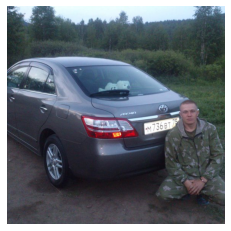

In [14]:
from PIL import Image
from io import BytesIO
img_url = image['img_local']

response = requests.get(img_url)
im = Image.open(BytesIO(response.content))
plt.imshow(im)
plt.axis('off')
plt.show()

The image is of a soldier dressed in military khakis. His face is visible. These details (aka martial imagery and at-least one visible face) are tracked in the `image` dictionary by-way-of the `img_classes` key. To see how, let’s print the indented contents of `image['img_classes']`.

**Code Listing 14: Printing the Image Classes**

In [15]:
from pprint import PrettyPrinter
PrettyPrinter().pprint(image['img_classes'])

{'cartoon_classifier': {'confidence': 0.8078071, 'is_cartoon': 0},
 'face_classifier': {'confidence': 1.0, 'has_face': 1},
 'soldier_classifier': {'confidence': 0.9754819, 'is_soldier': 1}}


The nested `img_classes` dictionary tracks the outputs of multiple classifiers that have been applied to this particular image. For example, the `soldier_classifier` tracks whether the person in the photo is dressed in military (as opposed to civilian) clothes. More relevantly for us, the `face_classifier` tracks whether a face is present in the image. Using this information, we can easily check for the presence of a face within a photograph.

**Code Listing 15: Checking Whether an Image Includes a Face**

In [16]:
image = invaders_filtered[0]['images'][0]
def has_face(image):
    return image['img_classes']['face_classifier']['has_face']

assert has_face(image)

Our current goal is facial recognition. Hence, there’s no point in analyzing images with no faces. Thus, let’s filter our dataset to just those suspects / images where faces are present. Afterwards, we’ll count the number of total suspects / images. Please note that a single invader can map to multiple social media images, so the image count can be higher than the final suspect count.

**Code Listing 16: Filtering Images Based on the Inclusion of a Face**

In [17]:
def filter_by_face(invaders):
    invaders_w_faces = []
    image_count = 0
    # We are careful to ensure that we don't override images in the original list.
    for invader in invaders[:]:
        images_w_faces = [image for image in invader['images'] if has_face(image)]
        if not images_w_faces:
            continue
            
        invader['images'] = images_w_faces
        invaders_w_faces.append(invader)
        image_count += len(images_w_faces)
    
    print(f"{image_count} images have faces, corresponding to {len(invaders_w_faces)} invaders.")
    return invaders_w_faces

invaders_w_faces = filter_by_face(invaders_filtered)

368 images have faces, corresponding to 166 invaders.


368 images have faces, corresponding to approximately 2.2 images per suspect. Let’s download these the images and store them locally for analysis. For simplicity’s sake, we’ll download the images sequentially and not in parallel, though it is worth noting that parallelization would yield a much faster download time.

**Code Listing 17: Downloading all Suspect Images**

In [18]:
import os
import time
def download_images(invaders, img_dir_name='suspect_photos'):
    if not os.path.exists(img_dir_name):
        os.makedirs(img_dir_name)
    
    start_time = time.time()
    image_count = 0
    for invader in invaders:
        for image in invader['images']:
            image_url = image['img_local']
            image_fname = os.path.join(img_dir_name, image_url.split('/')[-1])
            response = requests.get(image_url)
            file = open(image_fname, "wb")
            file.write(response.content)
            file.close()
            image_count += 1
            
    run_time = (time.time() - start_time) / 60
    print(f"It took {run_time:0.1f} minutes to download all {image_count} suspect images.")
    
download_images(invaders_w_faces)

It took 5.8 minutes to download all 368 suspect images.


It took less than 10 minutes download all the suspect images. Now, we can proceed to match all suspect faces with the killer;s face.

## Matching Suspect Faces to the Killer

We’ll start by extracting faces from each downloaded image and storing these faces within the associated `image` dictionary.

**Code Listing 18: Extracting Suspect Faces**

In [19]:
def add_invader_faces(invaders, img_dir_name ='suspect_photos'):
    start_time = time.time()
    for invader in invaders:
        for image in invader['images']:
            image_url = image['img_local']
            fname = os.path.join(img_dir_name, image_url.split('/')[-1])
            image['faces'] = RetinaFace.extract_faces(fname)

    
    run_time = (time.time() - start_time) / 60
    print(f"It took {run_time:0.1f} minutes to detect faces in all suspect images.")
    
add_invader_faces(invaders_w_faces)

It took 12.2 minutes to detect faces in all suspect images.


It took over 10 minutes to detect all the faces. Face detection / alignment is a computationally intensive process. Fortunately, this is a process that we only to execute once. We can reuse the faces in future analyses by caching them locally, using Python’s `pickle` module. 

**Code Listing 19: Caching Faces Locally**

In [20]:
import pickle
def pickle_invaders(invaders, fname='invaders.pkl', pickle_dir_name ='pickled_orcs'):
    if not os.path.exists(pickle_dir_name):
        os.makedirs(pickle_dir_name)
        
    file = open(os.path.join(pickle_dir_name, fname), 'wb')
    pickle.dump(invaders, file)
    file.close() 
                
pickle_invaders(invaders_w_faces)

Now we are ready to carry out facial recognition using the` DeepFace.verify` function. The function takes as input two faces and returns a dictionary of comparison statistics. Let’s see what happens when compare the killer’s face (aka `murderer_face`) with itself. Based on our expectations, that comparison should return a perfect match.

**Code Listing 20: Comparing the Killer’s Face with Itself**

In [21]:
#The `detector_backend` parameter is set to `skip` since the faces have already been detected and extracted.
face_compare = DeepFace.verify(murderer_face, murderer_face, detector_backend='skip')
print(face_compare)

{'verified': True, 'distance': 2.220446049250313e-16, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'skip', 'similarity_metric': 'cosine'}


The `distance` key in our result maps to the distance between `murderer_face` and itself.
Based on the `distance_metric` key, we know the comparison was carried out using the [cosine distance]( https://medium.datadriveninvestor.com/cosine-similarity-cosine-distance-6571387f9bf8), which is a common similarity measure between numerical arrays. This metric has a range between 0.0 (the arrays are identical) and 1.0 (are the arrays have nothing in common). The DeepFace model has compressed the inputted faces into smaller numerical arrays, and subsequently computed the cosine distance between them. As expected, that distance is essentially 0.0 (The reason we see `2e-16` is due to tiny, insignificant floating-point fluctuations). Hence the two faces are deemed a match. That is why the `verified` key maps to `True`. 

Now let’s see what happens when we compare `murderer_face` with some other face in our dataset.

**Code Listing 21: Comparing the Killer with Some Suspect**

In [22]:
face = invaders_w_faces[-1]['images'][0]['faces'][0]
face_compare = DeepFace.verify(face, murderer_face, detector_backend='skip')
print(face_compare)

{'verified': False, 'distance': 0.7892995248647938, 'threshold': 0.4, 'model': 'VGG-Face', 'detector_backend': 'skip', 'similarity_metric': 'cosine'}


The chosen face is not a match, since `verified` is set to False. The two faces do not match because the cosine distance between them is 0.789, which is quite large. What is maximum distance at which a match is possible? Well, that value is actually specified by `threshold` key within the dictionary, which currently maps to 0.40. In other words, the cosine distance between faces must be less than or equal to 0.40 for `DeepFace` to return a match.

With this mind, let’s compute the cosine distances between our target-face and all suspect faces in the data. For simplicity’s sake, we’ll iteratively analyze each face sequentially, though of course the process could be carried out much faster using parallelization. 

**Code Listing 22: Comparing the Killer with All Suspects**

In [23]:
def compare_faces(invaders, target_face):
    """This function computes the cosine distance between a `target_face` and each supsect_face
    within the `invaders` list."""
    start_time = time.time()
    for invader in invaders:
        for image in invader['images']:
            # The `faces` dictionary is updated to contain both the faces as well as their distance
            # to the target.
            updated_faces = [{'face': face, 
                              'distance': DeepFace.verify(face, target_face, 
                                                          detector_backend='skip')['distance']
                             }
                            for face in image['faces']]
            image['faces'] = updated_faces
          
    run_time = (time.time() - start_time) / 60
    print(f"It took {run_time:0.1f} minutes to compare all images to the target.")
    
compare_faces(invaders_w_faces, murderer_face)

It took 5.1 minutes to compare all images to the target.


We finished computing the distances between our suspects and our target; `murderer_face`. Now, let’s search for matches in our data based on a maximum distance threshold, which we’ll pre-set to 0.40. We filter on these matches such that:

1. Only faces whose distance falls below the minimal threshold will remain.
2. Only images with at-least one matched face will remain.
3. Only suspects with at-least one matched image will remain.

In other words, all unmatched faces / images / invaders will be filtered out. With this in mind, let’s carry out the filtering and then count the number of matches faces / images / invaders.

**Code Listing 23: Filtering Matched Faces by Cosine Distance**

In [24]:
def get_face_matches(invaders, max_distance=0.40):
    """This function filters the `invaders` list to just those invaders / images / faces
    that match our target. The `max_distance` parameter designates the maximum cosine
    distance required for a match."""
    matched_face_count = 0
    matched_image_count = 0
    # Tracks matched invaders.
    matched_invaders = []
    for invader in invaders[:]:

        matched_images = []
        for image in invader['images'][:]:
            matched_faces = []

            if 'faces' not in image:
                continue
            # Checks for facial matches that fall below the distance threshold
            faces = [face for face in image['faces'] if face['distance'] <= max_distance]
            if not faces:
                # No faces matched.
                continue
            
            matched_face_count += len(faces)
            image['faces'] = faces
            # Adds the matched image.
            matched_images.append(image)

        if not matched_images:
            # No matched images.
            continue
        
        # Adds the matched invader.
        invader['images'] = matched_images
        matched_image_count += len(matched_images)
        matched_invaders.append(invader)

    print(f"We matched {matched_face_count} faces across {matched_image_count} images across" 
          f" {len(matched_invaders)} invaders")
    return matched_invaders
    
matched_invaders = get_face_matches(invaders_w_faces)

We matched 149 faces across 131 images across 82 invaders


Our current distance threshold matches 149 faces across 82 invaders. This is too many faces to review by hand. Clearly, our threshold is too lenient. We need to tighten it to a lower, more constrained value. What new threshold should we use? In order to find out, we’ll plot a histogram of measured cosine distances. Afterwards, we'll choose a threshold based on the shape of that histogram.

**Code Listing 24: Plotting a Histogram of Cosine Distances**

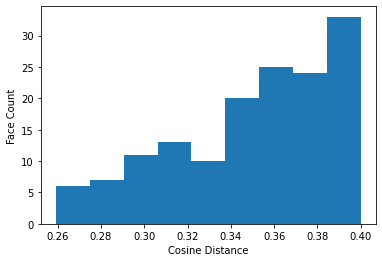

In [25]:
matched_faces = []
for invader in matched_invaders:
    for image in invader['images']:
        matched_faces.extend(image['faces'])
    
similarities = [face['distance'] for face in matched_faces]
plt.hist(similarities, bins='auto')
plt.xlabel('Cosine Distance')
plt.ylabel('Face Count')
plt.show()

According to our histogram, over 30 faces have distance of approximately 0.40. That binned face-count drops as the distance drops. The most radical drop occurs at the distance of 0.34, when the face-count is halved from 20 to approximately 10. A second drop occurs at distance of 0.29, when the face-count falls from 10 to approximately 5. Let’s emphasize this second drop by adding a vertical line to the plotted histogram demarcating a threshold of 0.29.

**Code Listing 25: Plotting a Histogram with a Distance Threshold**

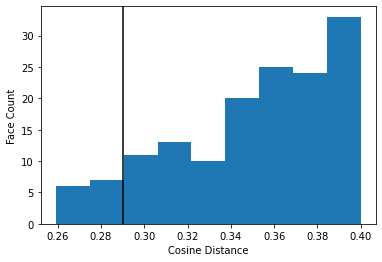

In [26]:
plt.hist(similarities, bins='auto')
plt.axvline(0.29, color='k')
plt.xlabel('Cosine Distance')
plt.ylabel('Face Count')
plt.show()

Filtering on a threshold of 0.29 should reasonably reduce our match-count while ensuring that the closest matches still remain within the dataset. Below, we'll filter on that threshold. 

**Code Listing 26: Filtering Based on the Chosen Threshold**

In [27]:
matched_invaders = get_face_matches(invaders_w_faces, max_distance=0.29)

We matched 13 faces across 13 images across 11 invaders


We’ve narrowed our list of suspects to just 11 invaders. This small suspect list can reasonably be reviewed by hand. Let’s review our top suspects in order to identify the murderer.

## Reviewing the Matched Suspects to Identify the Murderer

We’ll start by sorting the suspects based on their minimal cosine distance to the murderer. This way, the best matches will appear at the very top of our list.

**Code Listing 27: Sorting the Suspects Based on Distance**

In [28]:
def sort_invader_matches(matched_invaders):
    """This function sorts our list of matched invaders based on cosine distance."""
    for invader in matched_invaders:
        # We analyze all matched images for each invader.
        images = invader['images']
        for image in images:
            # Assigns a minimal distance to each image.
            image['min_dist'] = min([face['distance'] for face in image['faces']])
        
        # Sorts images based on minimal distance to target.
        invader['images'] = sorted(invader['images'], key=lambda x: x['min_dist']) 
    
    # Invaders are sorted based on their minimal distance to the suspect.
    return sorted(matched_invaders, key=lambda x: x['images'][0]['min_dist'])

sorted_invader_matches = sort_invader_matches(matched_invaders)

Now, we need to do a detailed review of our sorted matches. For each matched suspect we want to:
1.	Compare the suspect’s face to that of the murderer. _If the suspect has multiple matched photos, we’ll first focus on the face with the smallest cosine distance._
2.	Review the original image from which the suspect’s face has been extracted. _The full image could provide additional clues that are not present in the face alone._

With this in mind, let’s define a function that will make it easier to review each suspect. The function will display the following three images, which will be adjacent to each other.

1.	Our target’s face.
2.	The suspect’s face. 
3.	The original image from the suspect’s face had been extracted.

Below, we’ll define ` visualize_match` and apply this function to the first two suspects in the `sorted_invader_matches` list.

**Code Listing 28: Visualizing the First Two Matched Suspects**

Name: Пилипчук Владимир Владимирович


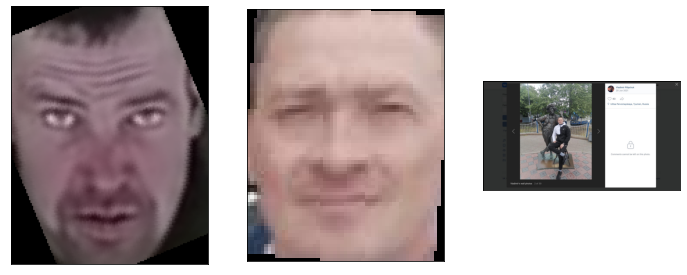

Name: Ендржеичик Андрей Николаевич


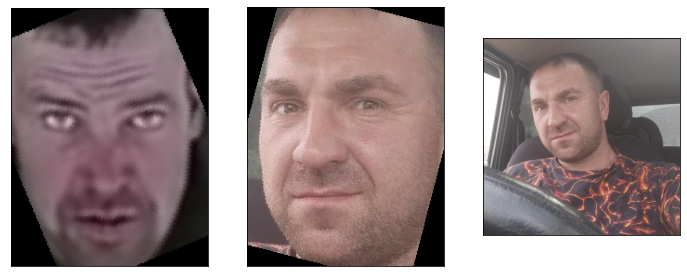

In [29]:
def visualize_match(invader, target_face=murderer_face, img_dir_name='suspect_photos'):
    """Visualizes a suspect's face along with the target face and the original target photo."""
    print(f"Name: {invader['name']}")
    # The images and faces have been sorted by cosine distance, so the first image contains the closest
    # match to `target_face`.
    image = invader['images'][0]
    # The closest matched face.
    match_face = image['faces'][0]['face'] 
    img_fname = os.path.join(img_dir_name, image['img_local'].split('/')[-1])
    # The full original image.
    original_image = mpimg.imread(img_fname)
    imgs_to_visualize = [target_face, match_face, original_image]
    # We visualize the three images across three axes positioned horizontally next to each other.
    _, axes, = plt.subplots(1, 3, figsize = (12, 12))
    for ax, img in zip(axes, imgs_to_visualize):
        # We plot each image on its individual axis.
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.xticks([])
    plt.show()

for invader in sorted_invader_matches[:2]:
    visualize_match(invader)

The two suspects bear some resemblance to the killer; they share the same unusually shaped nose. However, the second suspects clearly not that man. This becomes particularly obvious when we zoom-out beyond the face and examine full suspect photo. We see that the suspect has a receding hairline; he’s going bold! Meanwhile, the killer has a full head of hair. Here, we encounter a major issue with today’s facial matching models; they cannot take hair into account. To some extent this makes sense, an individual’s hair can drastically change after a single visit to the barber. Furthermore, a bolding individual can easily wear a wig, making hair (or lack-thereof) an unreliable variable (in theory). Nonetheless, a man who’s clearly going bold should not be getting matched to a man with hair, even if their noses look alike. Current models cannot handle such nuance. Thus, manual review is always required when considering suspect matches.

Our second suspect has been cleared (in regards to this particular war crime). Let’s add his name (_Ендржеичик Андрей Николаевич_) to a `cleared_suspects` list. Later, we’ll return to those suspects that haven’t been cleared and review them in more detail.

**Code Listing 29: Defining a Cleared Suspects List**

In [30]:
cleared_suspects = ["Ендржеичик Андрей Николаевич"]

Now let’s visualize the next five suspects, at indices 2 – 6 (exclusive) of the `sorted_invader_matches` list.

**Code Listing 30: Visualizing Four Additional Suspects**

Index: 2
Name: Каргин Герман Евгеньевич


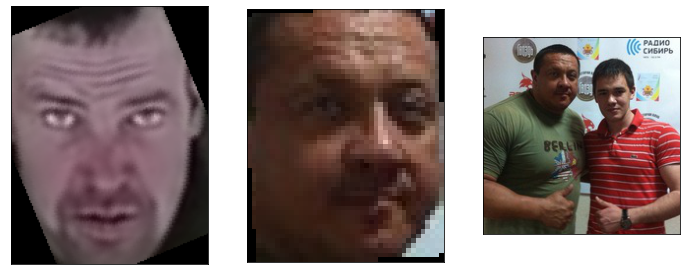

Index: 3
Name: Хозинский Константин Владимирович


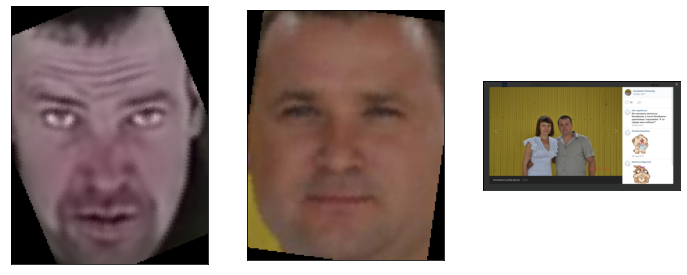

Index: 4
Name: Попов Алексей Васильевич


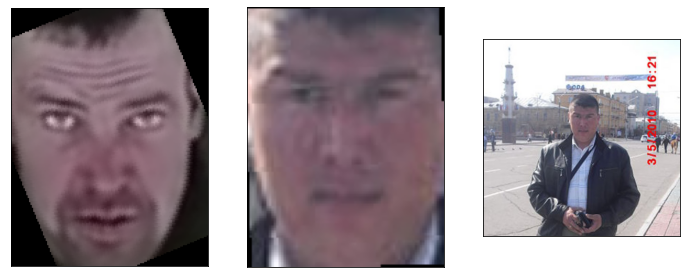

Index: 5
Name: Селезнев Алексей Владимирович


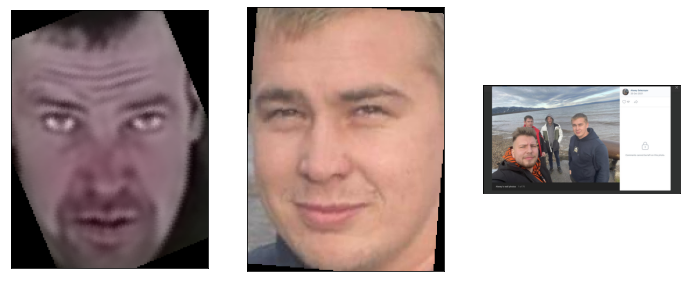

In [31]:
for index in range(2, 6):
    print(f"Index: {index}")
    visualize_match(sorted_invader_matches[index])

Glancing at the matches we can see that:


1. The suspect at Index 2 (Каргин Герман Евгеньевич) is clearly not the killer. He is much bulkier in terms of both fat and muscle than the lanky killer in our original image.
2. The suspect at Index 3 (Хозинский Константин Владимирович) is probably not the killer.  He is tubbier, and also the same height as the woman in the zoomed-out photo. Whereas the killer is long-limbed, and per our expectations, is probably taller than average.
3. The suspect at Index 5 (Селезнев Алексей Владимирович) is not the killer. His hair is dirty blond, whereas the killer’s hair is noticeably darker.

Let’s add these three cleared names to the `cleared_suspects` list.

**Code Listing 31: Updating the Cleared Suspects List**

In [32]:
cleared_suspects.extend(['Каргин Герман Евгеньевич', 'Хозинский Константин Владимирович', 'Селезнев Алексей Владимирович'])

Next, we’ll visualize the remaining five suspects.

**Code Listing 32: Visualizing the Remaining Five Suspects**

Index: 6
Name: Болдырев Олег Николаевич


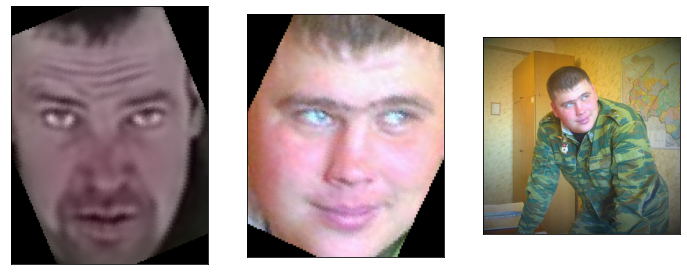

Index: 7
Name: Лапшаков Дмитрий Сергеевич


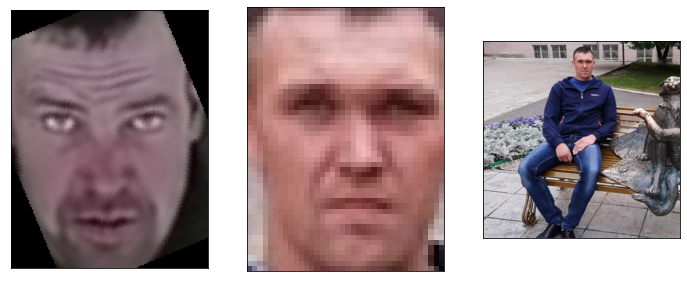

Index: 8
Name: Мальянов Борис Андреевич


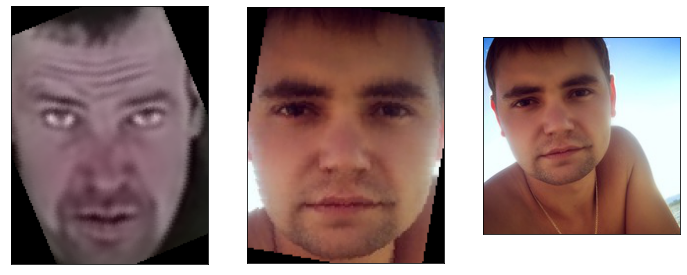

Index: 9
Name: Лукьянов Виктор Викторович


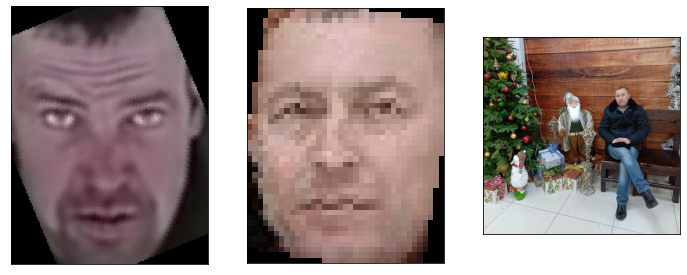

Index: 10
Name: Заводин Александр Андреевич


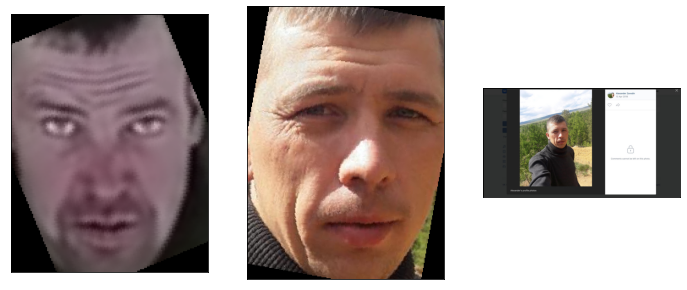

In [33]:
for index in range(6, len(sorted_invader_matches)):
    print(f"Index: {index}")
    visualize_match(sorted_invader_matches[index])
        

From the final five matches we see that:

1. The suspect at Index 6 (Болдырев Олег Николаевич) is not the killer. He has a unibrow and is more heavy-set. Given his arm uniform in the zoomed-out photo, it’s reasonable to assume that the photograph was taken fairly recently, and that the soldier hadn’t undergone drastic changes in appearance when the war-crime was committed.

2. The suspect at Index 8 (Мальянов Борис Андреевич) looks much younger than the killer. However, this doesn’t necessarily disqualify the suspect. We do not know how long ago this photo was taken. It’s possible that the photo was obtained many years ago, when the suspect was still a teenager. Hence, we cannot rule a suspect out just because he appears to young in a matched photo. On the other hand, the suspect’s face is slightly rounder than the oval face of the killers. More importantly, the suspect’s eyebrows are very bushy, while the killer’s eyebrows are thinned. It’s highly unlikely that the unshaven killer took his time to trim his eyebrows while preparing to invade a sovereign land. Hence, we can assume that this suspect is not the killer.

Let’s add two more names to the `cleared_killers` list. Afterwards, we’ll filter our list of suspects based on names not on that list. We’ll then count the remaining suspects and visualize their photos.

**Code Listing 33: Visualizing all the Uncleared Suspects**

The following 5 suspects remain.
Index: 0
Name: Пилипчук Владимир Владимирович


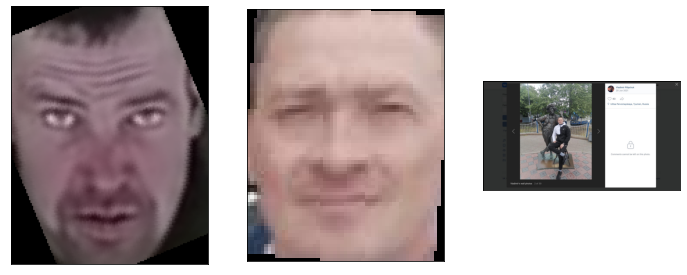

Index: 1
Name: Попов Алексей Васильевич


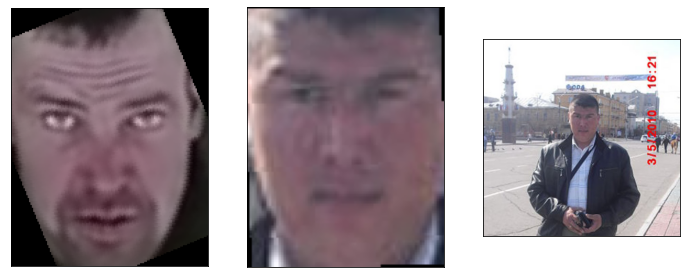

Index: 2
Name: Лапшаков Дмитрий Сергеевич


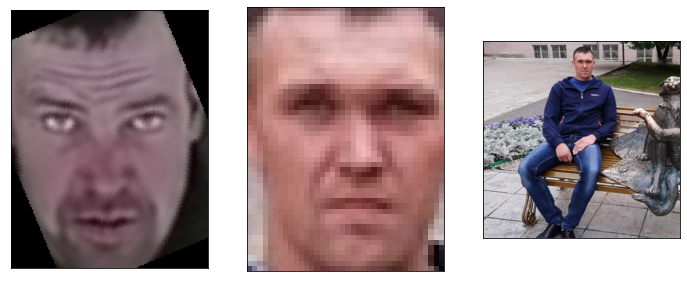

Index: 3
Name: Лукьянов Виктор Викторович


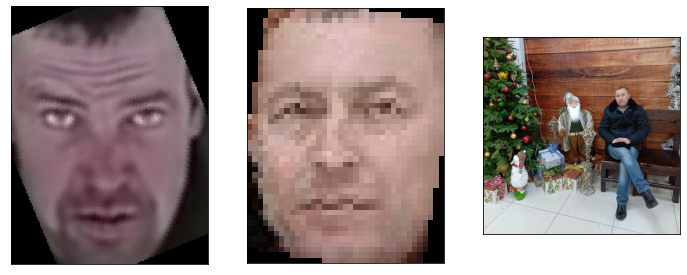

Index: 4
Name: Заводин Александр Андреевич


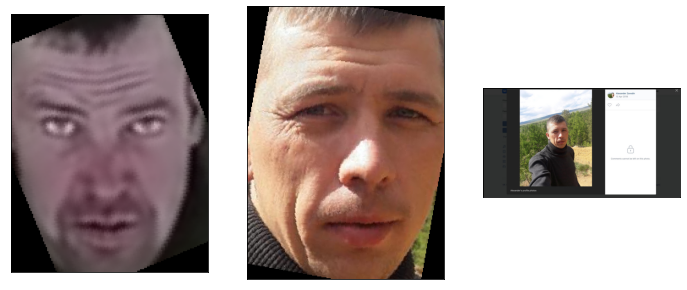

In [34]:
cleared_suspects.extend(['Болдырев Олег Николаевич', 'Мальянов Борис Андреевич'])
remaining_suspects = [invader for invader in sorted_invader_matches if invader['name'] not in cleared_suspects]
print(f"The following {len(remaining_suspects)} suspects remain.")
for index, suspect in enumerate(remaining_suspects):
    print(f"Index: {index}")
    visualize_match(suspect)

Just five suspects remain. We can easily examine the suspects manually. From our list, one suspect, Лапшаков Дмитрий Сергеевич (Dimitri Lapshakov) at Index 2 particularly stands out. We’ll soon discuss why, but first let’s visualize Dimitri separately, along with the original killer’s photo.

**Code Listing 34: Visualizing Dimitri Lapshakov**

Name: Лапшаков Дмитрий Сергеевич


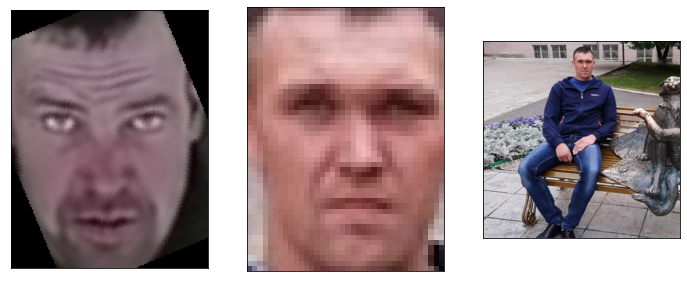

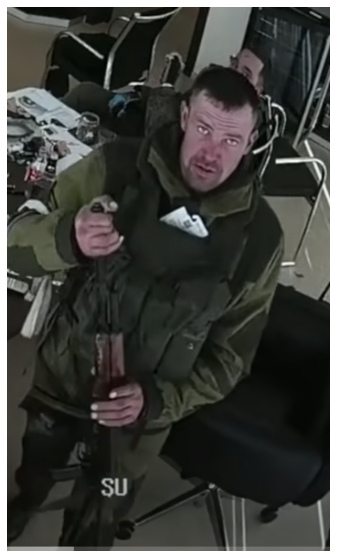

In [35]:
visualize_match(remaining_suspects[2])
plt.figure(figsize = (10, 10))
plt.imshow(murderer_image)
plt.axis('off')
plt.show()

Dimitri shares the same elongated nose as the killer; similar eyebrows, similar brown, short hair. From the zoomed-out photograph, we see that Dimitri is long-limbed just like the killer is long-limbed. There is good reason to believe that Dimitri might be the murderer. In fact, he is the murderer! Ukrainian news sites have [confirmed](https://news.liga.net/politics/news/jurnalisty-ustanovili-imya-odnogo-iz-uchastnikov-ubiystva-grajdanskih-pod-kievom-smi) that [Dimitri Lapshakov](https://twitter.com/Flash43191300/status/1525529063300866050) is the killer recorded in the video.


We have correctly identified the killer, after reviewing 10 other false positives. These false positives arose due to various inadequacies in our model, which include the inability to compare hair and body type. Given that we started with a filtered list of 166 suspects, these results imply that our false positive rate is approximately 6%. Imagine if we hadn't filtered by age and military unit. We would’ve had to manually review approximately 2,000 photos before identifying Dimitri! Consequently, when we utilize open-source tools, it is imperative that we suspects based on researched information. Of course, given the ambiguity of available data, it is not always possible to narrow our suspect-range down to a single military unit. In such instances, additional filtration constraints are required to keep the suspect list small. In the subsequent section, we will explore a more difficult scenario, in which a war criminal’s military unit is not precisely known.

## Identifying a War Criminal When their Military Unit is Ambiguous 


A New York Times investigation had revealed a [horrifying video]( https://twitter.com/nytimes/status/1527412578397433857?lang=en) of eight Ukrainians being massacred in Bucha. The executions took place in a courtyard outside [144 Yablunska street]( https://twitter.com/UkraineNewsLive/status/1527487303093985285). A surveillance camera opposite 144 Yablunska street [recorded several Russian invaders]( https://twitter.com/AlexKhrebet/status/1527602533950271491) who were present around the time of the executions. Below, we’ll visualize one of these men.

**Code Listing 35: Visualizing Another War Criminal**

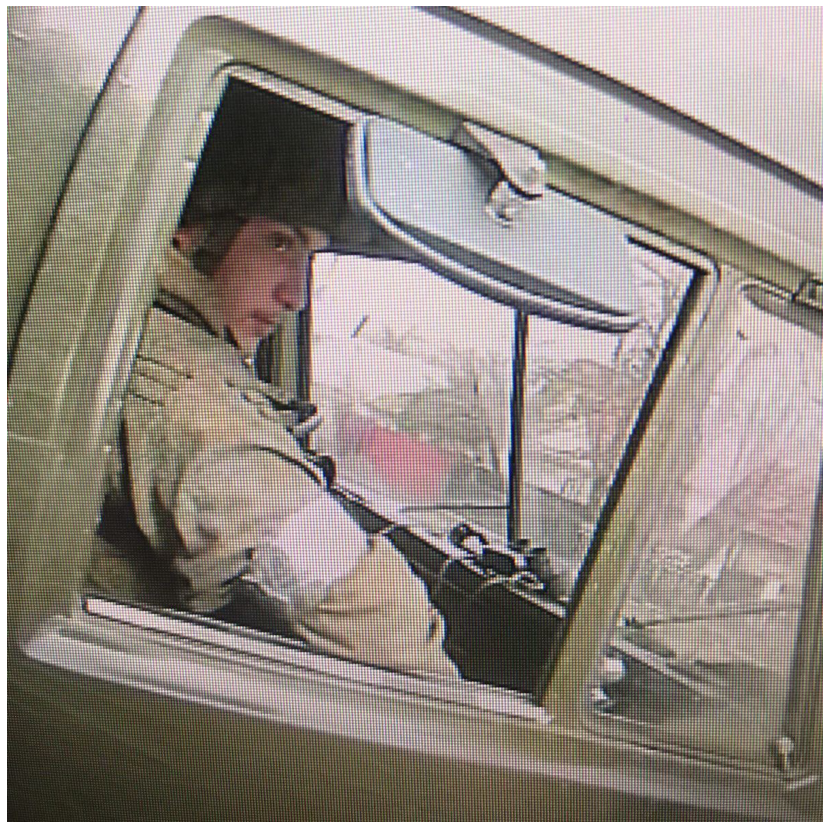

In [36]:
image_path = 'war_criminals/bucha_driver.jpeg'
plt.figure(figsize = (15, 15))
plt.imshow(mpimg.imread(image_path))
plt.axis('off')
plt.show()

The invader looks young; younger than 30. He sits behind the wheel of military vehicle, which is partially obscuring his physique. However, his face is clearly visible. Let’s extract the driver’s face.

**Code Listing 36:  Extracting the Driver’s Face**

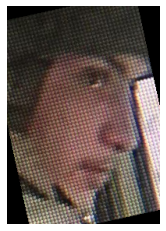

In [37]:
driver_face = RetinaFace.extract_faces(image_path)[0]
plot_face(driver_face)

In order to identify the driver, we must research the military unit that was present in Bucha at the time. Some of the worst atrocities in Bucha had been committed by the [64th Separate Guards Motor Rifle Brigade]( https://en.wikipedia.org/wiki/64th_Separate_Guards_Motor_Rifle_Brigade#Russian_invasion_of_Ukraine) whose military unit number is [51460]( https://twitter.com/visegrad24/status/1511715646605860864) . It would make sense that the young driver is a member of that motor brigade. The situation, however, is not so simple. The New York Times has uncovered [packing slips for crates of ammunition](https://www.nytimes.com/2022/05/19/world/europe/russia-bucha-ukraine-executions.html) at the execution site (see below). The packing slips belong to military units 32515 and 74268, which are both paratrooper divisions.

**Code Listing 37:  Visualizing Packing Slips Found at the Execution Site**

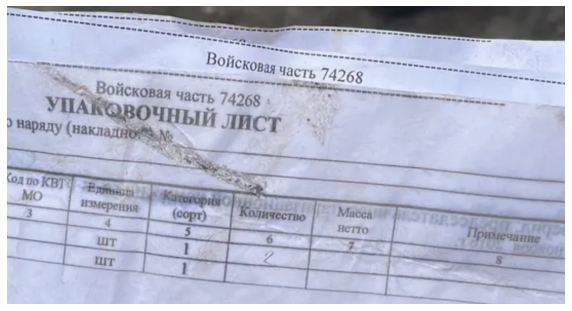

In [38]:
image = mpimg.imread('images/packing_slip.png')
plt.figure(figsize = (10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()

Is the driver a paratrooper, or does he serve in the motor rifle brigade? We don’t yet know, so we will need to consider all three military units. This of course will elevate our list of possible suspects, therefore increasing the number of false positives. Eventually, we’ll need to take additional steps to filter down our list of suspects. For now, however, we will stick to our previously developed filtration pipeline. Let’s do the following:

1. First we’ll filter the full `invaders` list to those suspects belong to one of the three military units (51450, 32515, or 74268).
2. Next, based on the driver’s youthful appearance, we’ll filter to just those suspects who are younger than 30.
3. Finally, we’ll filter to just those suspects that are linked to an image with a face.
 
**Code Listing 38:  Filtering the Suspect List**

In [39]:
# We download the invaders json from scratch, to remove effects of any previous filtering.
invaders = requests.get("https://invader.info/files/invaders.json").json()
# This regular expression matches to the three military units.
regex_string = '(51460|32515|74268)'
# We filter suspects based on military unit.
invaders_filtered = filter_by_military_unit(invaders, regex_string)
# We filter suspects based on age.
invaders_filtered = [invader for invader in invaders_filtered if get_approx_age(invader) < 30]
print(f'{len(invaders_filtered)} invaders are associated with the 3 military units and are younger than 30.')
# We filter suspects based on the presence of a face in at-least one image.
invaders_w_faces = filter_by_face(invaders_filtered)

480 invaders are associated with the 3 military units and are younger than 30.
1346 images have faces, corresponding to 411 invaders.


We filtered our list to 411 suspects, more than double the amount that we encountered in our previous investigation. Given the false positive rate of 6%, we can expect to encounter 24 false positives. Fortunately, we won’t have review all these false positives, due to an additional filtration step that we will present later in this section. 

For now, let’s just download and analyze the images. We’ll proceed to:
1. Download the suspect images.
2. Extract all faces from those images.
3. Compare the extracted faces to `driver_face` and compute the cosine similarities.

**Code Listing 39: Extracting and Comparing the Faces**

In [40]:
# Dowload the images.
download_images(invaders_w_faces, img_dir_name ='suspect_photos_bucha')
# Extract faces from images.
add_invader_faces(invaders_w_faces, img_dir_name='suspect_photos_bucha')
# Save the extracted faces for additional analysis if neccessary.
pickle_invaders(invaders_w_faces, fname="invaders_bucha.pkl")
# Compute the cosine similarites between `driver_face` and all the suspect faces.
compare_faces(invaders_w_faces, driver_face)

It took 27.0 minutes to download all 1346 suspect images.
It took 54.0 minutes to detect faces in all suspect images.
It took 14.7 minutes to compare all images to the target.


Previously, we defined a suspect match based on a maximum face maximum of 0.29. That maximum cutoff was derived after examining the histogram of cosine distance values. At 0.29, we previously saw a noticeable dip in binned face counts. Let's check whether our cutoff is still valid by generating a histogram based on our latest suspect data. We’ll also plot a vertical black line at our current cutoff if 0.29. In all goes well, that line should intersect with a face-count dip within the histogram.

**Code Listing 40: Plotting a Histogram of Cosine Distances**

We matched 856 faces across 573 images across 270 invaders


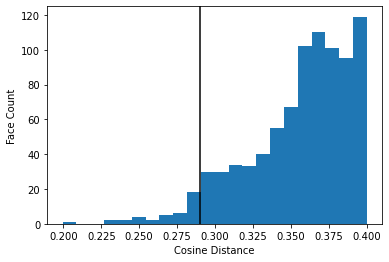

In [41]:
matched_invaders = get_face_matches(invaders_w_faces)
matched_faces = []
for invader in matched_invaders:
    for image in invader['images']:
        matched_faces.extend(image['faces'])
    
similarities = [face['distance'] for face in matched_faces]
plt.hist(similarities, bins='auto')
plt.axvline(0.29, color='k')
plt.xlabel('Cosine Distance')
plt.ylabel('Face Count')
plt.show()

As expected, the histogram dips at the plotted cutoff. Objectively, the cosine distance of 0.29 is a good choice for our filtration threshold.  We’ll now utilize that threshold to filter our matches.

**Code Listing 41: Filtering Matched Faces Based on Distance**

In [42]:
matched_invaders = get_face_matches(invaders_w_faces, max_distance=0.29)

We matched 38 faces across 34 images across 27 invaders


We’ve filtered down our data to 27 suspects. If one of our suspects is indeed the driver, then we are dealing with 26 false positives. This aligns with our expected false positive rate of 6%.  Let’s sort our 27 suspects based on distance and visualize the first suspect in the sorted list. 

**Code Listing 42: Visualizing the First Suspect Match**

Name: Заколюкин Дмитрий Эдуардович


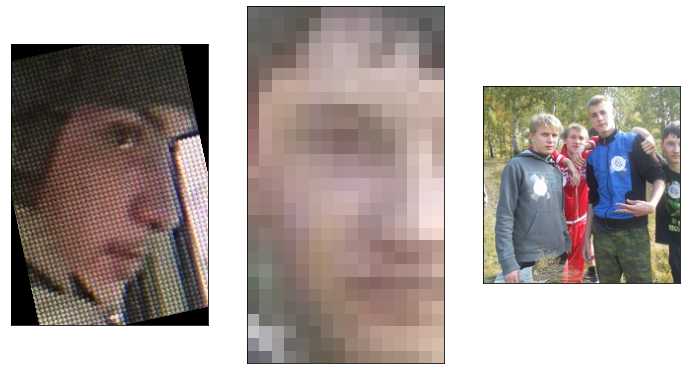

In [43]:
# Sortes suspects based on distance to the target face.
sorted_invader_matches = sort_invader_matches(matched_invaders)
visualize_match(sorted_invader_matches[0], target_face=driver_face, img_dir_name='suspect_photos_bucha')

The suspect’s face is very blurry. His face-image resolution is so low that the face is practically indecipherable. The resolution is low because the suspect was photographed from afar. In the zoomed-out photograph, his face is small, even though his full body visible. Normally, this full-body perspective can be useful. In our previous analysis, we helped confirm our killer based on his long limbs in the zoomed-out photo. However, our driver’s limbs remain obscured; we have no use for far-away full-body photos. On the contrary, the low-resolution images resulting from such photos are elevating our false positive rate. Thus, we can reduce the false positive rate if we remove all faces that have too low a resolution.

##  Filtering Out Low Resolution Faces
Before we measure the resolution of a face, we must explore the datatype in which is face is currently stored. Let’s grab the first face in `sorted_suspect_matches` and print its datatype using Python’s built-in `type` function.

**Code Listing 43: Check the Datatype of a Face**

In [44]:
invader = sorted_invader_matches[0]
face = invader['images'][0]['faces'][0]['face']
print(type(face))

<class 'numpy.ndarray'>


Our  `face` variable is a NumPy array, which means that’s it’s a [multidimensional table]( https://numpy.org/doc/stable/reference/arrays.ndarray.html) of numeric values. Such tables have a [shape]( https://numpy.org/doc/stable/reference/generated/numpy.shape.html), which we can print using the `face.shape` attribute. 

**Code Listing 44:  Outputting the Shape of a Face Array**

In [45]:
print(face.shape)

(29, 16, 3)


The image shape returns three elements; 29, 16, 3. Basically, the image is a 3D box with length 29, width 16, and height 3. The three-element height corresponds to the [three primary colors]( https://www.britannica.com/science/primary-color); red green, and blue. These colors can be mixed in various proportions to generate any other color. Essentially, the multi-color image is generated by summing three rectangular tables. Each table tracks the quantity of a primary color that is to be applied to a single pixel. Each table 29 rows and 16 columns, corresponding to `29 * 16` total pixels. The [pixel resolution](https://www.tutorialspoint.com/dip/pixel_resolution.htm) is equal to that total row-by-column product. Let’s score the resolution of the first face in our list and compare it with the resolution of the driver’s target face.

**Code Listing 45: Comparing Facial Resolutions**

In [46]:
def get_resolution(face):
    num_rows, num_columns, _ = face.shape
    return num_rows * num_columns

res_face = get_resolution(face)
res_driver = get_resolution(driver_face)
res_ratio = int(res_driver / res_face)
print(f"The resolution of the the first face in our list is {res_face} pixels.")
print(f"The resolution of the driver's face is {res_driver} pixels.")
print(f"The driver has a {res_ratio}-fold higher resolution than the face.")

The resolution of the the first face in our list is 464 pixels.
The resolution of the driver's face is 54880 pixels.
The driver has a 118-fold higher resolution than the face.


While the driver’s face contains nearly 55,000 pixels, the resolution of the first face is incredibly low. It contains less than 400 pixels. Consequently, the face with the closest cosine distance to the driver is nearly indecipherable. This is not a coincidence. At higher resolutions, faces have more distinguishing features. Two smudgy, low-res faces that seem nearly identical might start to look more different as the resolution is increased. Conversely, low-resolution faces are easier to match. That is why police are more likely to misidentifying a suspect when the video of a crime is blurry and steeped in shadows. That is also why our cosine distance metric is more prone to erroneously match faces when their resolution is low. Basically, lower resolution correlates with lower cosine distance, which also leads to more false positives. We’ll demonstrate this below, by generating a scatter plot of resolution vs cosine distance for each face contained in `sorted_invader_matches`. We’ll also mark the resolution of the driver’s face within the plot as a horizontal line, for easier comparison. Finally, we’ll add a horizontal low-resolution threshold, equal to 1/4th the resolution of the driver. We’ll assume that all the faces falling below that threshold are of lower quality.

**Code Listing 46: Plotting Cosine Distance vs Face Resolution**

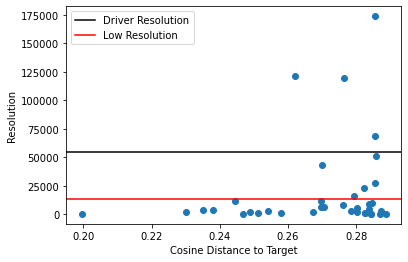

In [47]:
resolutions = []
distances = []
for invader in sorted_invader_matches:
    for image in invader['images']:
        for face in image['faces']:
            res = get_resolution(face['face'])
            resolutions.append(res)
            distances.append(face['distance'])
            

plt.axhline(res_driver, color='k', label='Driver Resolution')
plt.axhline(res_driver / 4, color='r', label='Low Resolution')
plt.scatter(distances, resolutions)
plt.xlabel('Cosine Distance to Target')
plt.ylabel('Resolution')
plt.legend()
plt.show()

Our plot helps qualitatively confirm that low-resolution correlates with distances. All faces below distance of 0.26 fall below the low-resolution threshold. These faces are more likely to be false positives. Suppose we were to filter out all faces below that threshold (which equals approximately 15K pixels). Based on our plot, that filtration would leave us with just 10 faces, which we could then proceed to manually examine. Additionally, we could make our resolution threshold even more stringent if we set it to the driver’s resolution. Selecting just those faces that have as many pixels as the driver would yield under five matches. More precisely, filtering on `res_driver` would yield four faces, corresponding to no more than four suspects. For simplicity’s sake, let’s see what happens when we filter based on `res_driver.`

**Code Listing 47: Filtering Faces Based on the Resolution of the Target Face**

Index: 0
Name: Шорчиков Владимир Григорьевич


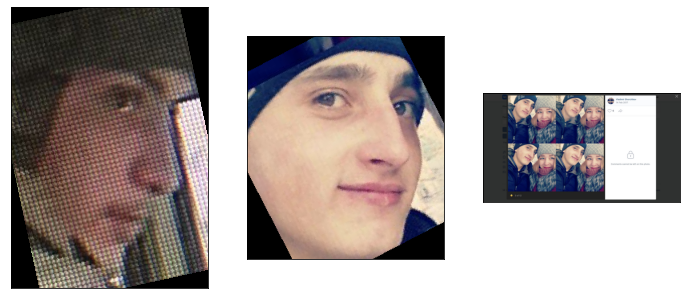

Index: 1
Name: Квашнин Сергей Дмитриевич


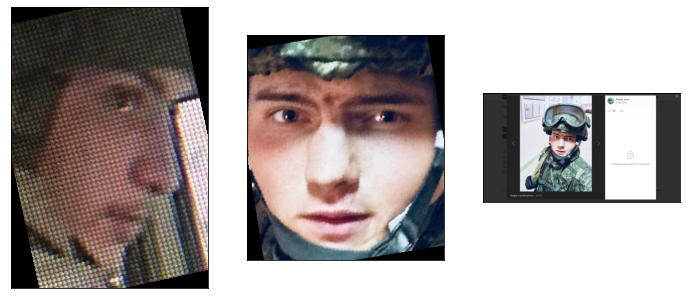

Index: 2
Name: Оломский Богдан Юрьевич


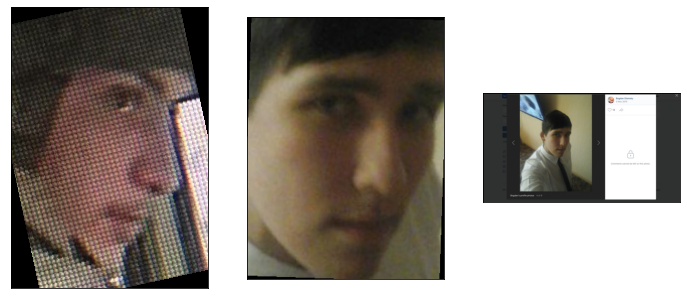

Index: 3
Name: Талько Бронислав Сергеевич


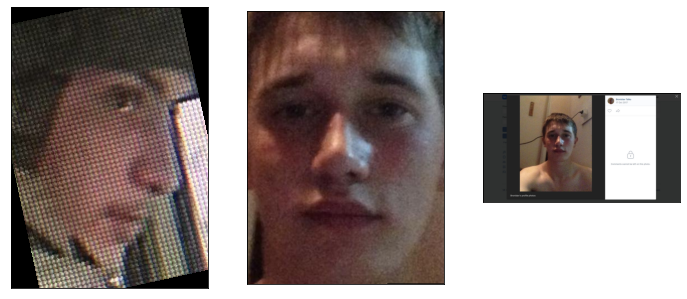

In [48]:
def filter_by_resolution(invaders, min_resolution):
    """This function filters the `invaders` list to just those invaders / images / faces
    that are >= `min_resolution`"""
    # Tracks matched invaders.
    matched_invaders = []
    for invader in invaders[:]:

        matched_images = []
        for image in invader['images'][:]:
            matched_faces = []
            # Checks for faces that are at or above the resolution threshold
            faces = [face for face in image['faces'] if get_resolution(face['face']) >= min_resolution]
            if not faces:
                continue
            image['faces'] = faces
            
            # Adds the matched image.
            matched_images.append(image)

        if not matched_images:
            continue
        
        # Adds the matched invader.
        invader['images'] = matched_images
        matched_invaders.append(invader)

    return matched_invaders

filtered_invader_matches = filter_by_resolution(sorted_invader_matches, res_driver)
for index, invader in enumerate(filtered_invader_matches):
    print(f"Index: {index}")
    visualize_match(invader, target_face=driver_face, img_dir_name='suspect_photos_bucha')

Resolution filtering returns just three suspects to review. The first suspect (Квашнин Сергей Дмитриевич) shares similar dark features with our driver; he has similar eyebrows and similar eyes. However, his bulbous nose clearly doesn’t match. Comparably, the nose of the third suspect (Квашнин Сергей Дмитриевич) does not align with the unique shape of the driver’s nose. We can cross both these suspects off our list. On the other hand, the middle suspect at Index 1 warrens a closer investigation.

**Code Listing 48: Examining the Best-Matched Suspect**

Name: Квашнин Сергей Дмитриевич


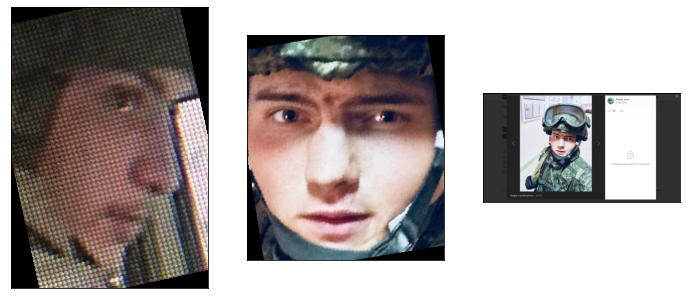

In [49]:
invader = filtered_invader_matches[1]
visualize_match(invader, target_face=driver_face, img_dir_name='suspect_photos_bucha')

According to a SMAT investigation, [numerous indicators converge]( https://blog.smat-app.com/p/vk-war-criminals) on [Bogdan Olomsky]( https://twitter.com/SMAT_app/status/1539992555596693504)  being the driver. We were able to replicate these findings using open-source data and open-source tools.

# Conclusions

Using combination of [open-source data]( https://invader.info/) and [open-source libraries]( https://github.com/serengil/deepface), we can accurately identify Russian war criminals from published video footage. Facial recognition algorithms work, though they do have certain limitations. The algorithms are unable to incorporate information pertaining to hair or body type. Additionally, the algorithms can sometimes get confused by low-resolution facial images. This results in false positive rate of 6% and necessitates manual review. Filtering the suspects by age and military unit helps limit that review to a reasonable number of facial matches. Additionally, the empirically determined cosine distance threshold of 0.29 is required to minimize the false positives. A minimum resolution threshold can also be useful, especially in those instances when a review of the suspect’s body-type is not required.

**The code featured in this blog-post is available for download at [https://github.com/DataSalo/war_crime_faces](https://github.com/DataSalo/war_crime_faces)**